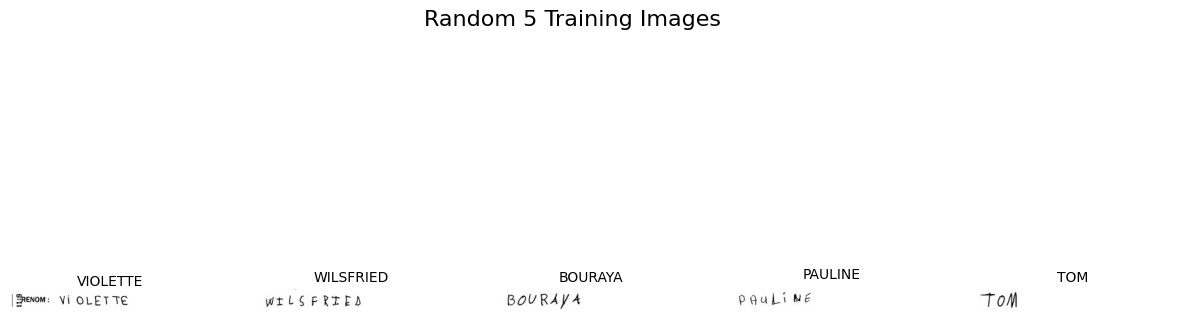

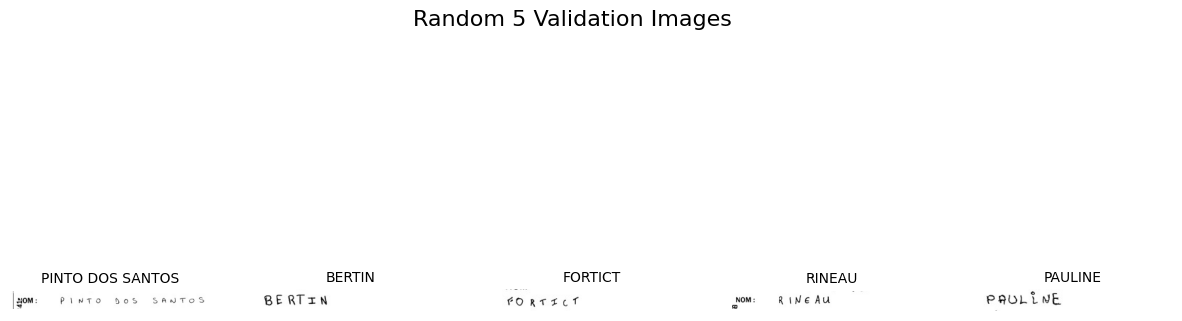

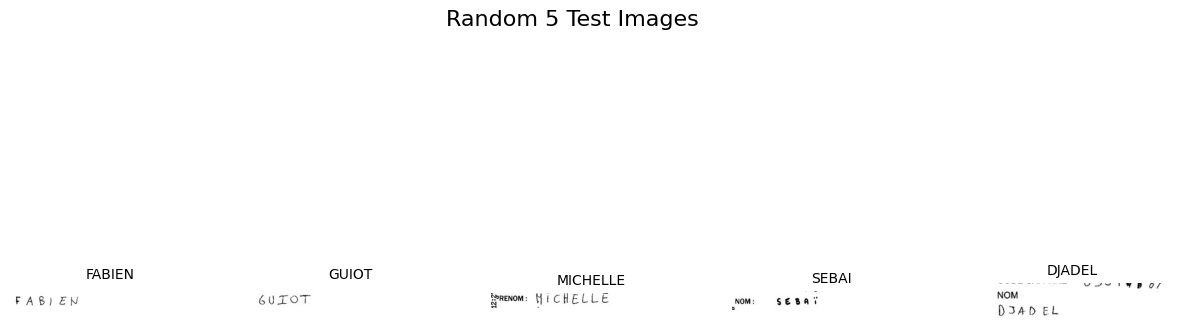

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import os

path = "/kaggle/input/handwriting-recognitionocr"

train_csv = f"{path}/CSV/written_name_train.csv"
valid_csv = f"{path}/CSV/written_name_test.csv"
test_csv  = f"{path}/CSV/written_name_validation.csv"

train_img_dir = f"{path}/train_v2/train"
valid_img_dir = f"{path}/test_v2/test"
test_img_dir  = f"{path}/validation_v2/validation"

# Load CSVs
train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)
test_df = pd.read_csv(test_csv)

def show_random_images(df, img_dir, title):
    samples = df.sample(5).reset_index(drop=True)
    
    plt.figure(figsize=(15, 6))
    plt.suptitle(title, fontsize=16)

    for i in range(5):
        img_name = samples.loc[i, "FILENAME"]
        label = samples.loc[i, "IDENTITY"]

        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Missing: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label, fontsize=10)

    plt.show()

# Show random 5 images from each dataset
show_random_images(train_df, train_img_dir, "Random 5 Training Images")
show_random_images(valid_df, valid_img_dir, "Random 5 Validation Images")
show_random_images(test_df, test_img_dir, "Random 5 Test Images")


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="os.fork() was called. os.fork() is incompatible with multithreaded code", category=RuntimeWarning)

In [3]:
!pip install "transformers>=4.40" peft accelerate bitsandbytes --no-deps
!pip install evaluate==0.4.0 --no-deps
!pip install jiwer==3.0.1
!pip install protobuf==3.20.3 --upgrade --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


In [5]:

import time
import math
import numpy as np
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
import evaluate
# from jiwer import compute_measur
from tqdm import tqdm


E0000 00:00:1765336465.178734      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765336465.231025      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from peft import LoraConfig, get_peft_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten", use_fast=True)

base_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

base_model.decoder.resize_token_embeddings(len(processor.tokenizer))



# 3. Set required generation config IDs
base_model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
base_model.config.pad_token_id = processor.tokenizer.pad_token_id
base_model.config.eos_token_id = processor.tokenizer.eos_token_id
base_model.config.vocab_size = base_model.decoder.config.vocab_size



print("Patched base decoder config.")

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
    lora_dropout=0.05,
    bias="none",
)


model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

model.config.vocab_size = processor.tokenizer.vocab_size
model.config.decoder.vocab_size = processor.tokenizer.vocab_size 
print(f"Patched PEFT model config with vocab_size: {model.config.vocab_size}")

model.to(device)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Patched base decoder config.
trainable params: 1,523,712 || all params: 335,445,504 || trainable%: 0.4542
Patched PEFT model config with vocab_size: 50265


PeftModel(
  (base_model): LoraModel(
    (model): VisionEncoderDecoderModel(
      (encoder): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViTLayer(
              (attention): ViTAttention(
                (attention): ViTSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=False)
                  (key): Linear(in_features=768, out_features=768, bias=False)
                  (value): Linear(in_features=768, out_features=768, bias=False)
                )
                (output): ViTSelfOutput(
                  (dense): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
             

In [7]:
# If model is PEFT-wrapped, ensuring it reports trainable params:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / Total params: {total:,}")

# training hyperparams (tweak as needed)
num_epochs = 3
accum_steps = 8
learning_rate = 1e-5
grad_clip = 1.0
save_every_n_steps = 500
output_dir = "./trocr_lora_manual"

# optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# mixed precision scaler (Fix for FutureWarning, and optimization)
use_amp = torch.cuda.is_available()
# Use torch.amp.GradScaler instead of the deprecated torch.cuda.amp.GradScaler
scaler = torch.amp.GradScaler(enabled=use_amp) if use_amp else None

# metrics
wer_metric = evaluate.load("wer")

Trainable params: 1,523,712 / Total params: 335,445,504


In [8]:

# helper: generate predictions for a batch of pixel_values (tensor on device)
def generate_preds(batch_pixel_values, max_length=64, num_beams=4):
    # batch_pixel_values: tensor (B, C, H, W)
    model.eval()
    with torch.no_grad():
        # model.generate expects pixel_values on the device
        generated_ids = model.generate(
            pixel_values=batch_pixel_values,
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            decoder_start_token_id=processor.tokenizer.bos_token_id,
        )
        preds = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return preds

# eval function (computes wer + exact match)
def evaluate_epoch(eval_loader, max_length=64, num_beams=4, limit=None):
    model.eval()
    pred_texts = []
    true_texts = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(eval_loader, desc="Eval")):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # fix labels: -100 -> pad token
            labels_for_decoding = labels.clone()
            labels_for_decoding[labels_for_decoding == -100] = processor.tokenizer.pad_token_id

            # decode
            label_strs = processor.batch_decode(labels_for_decoding, skip_special_tokens=True)
            label_strs = [s.strip() for s in label_strs]

            # generate preds
            preds = generate_preds(pixel_values, max_length=max_length, num_beams=num_beams)
            preds = [s.strip() for s in preds]

            # append
            true_texts.extend(label_strs)
            pred_texts.extend(preds)

            if limit and i >= limit:
                break

    # -------------------------------------------------------
    # 🔥 FILTER OUT EMPTY REFERENCES (required for WER)
    # -------------------------------------------------------
    filtered_preds = []
    filtered_refs = []

    for p, r in zip(pred_texts, true_texts):
        if r != "":
            filtered_preds.append(p)
            filtered_refs.append(r)

    if len(filtered_refs) == 0:
        print("WARNING: All references were empty! Returning dummy metrics.")
        return {"wer": 1.0, "exact_match": 0.0, "preds": [], "refs": []}

    # compute metrics
    wer = wer_metric.compute(predictions=filtered_preds, references=filtered_refs)
    exact = sum(1 for a, b in zip(filtered_preds, filtered_refs) if a == b) / len(filtered_refs)

    return {
        "wer": wer,
        "exact_match": exact,
        "preds": filtered_preds[:5],
        "refs": filtered_refs[:5],
    }


    # compute metrics
    wer = wer_metric.compute(predictions=pred_texts, references=true_texts)
    exact = sum(1 for a,b in zip(pred_texts, true_texts) if a.strip()==b.strip()) / max(1, len(pred_texts))
    return {"wer": wer, "exact_match": exact, "preds": pred_texts[:5], "refs": true_texts[:5]}


In [9]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import TrOCRProcessor

# --- REVISED HandwritingDataset CLASS ---
class HandwritingDataset(Dataset):
    def __init__(self, df, processor, max_target_length=64):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["full_path"]
        label = row["IDENTITY"]

        image = Image.open(img_path).convert("RGB")

        # 🚀 FIX 1: Separate image processing (feature_extractor) and text tokenization (tokenizer)
        # This prevents the 'Unused or unrecognized kwargs' warnings.
        pixel_values = self.processor.feature_extractor(
            image,
            return_tensors="pt"
        ).pixel_values.squeeze(0)

        # Tokenize text/labels separately
        labels = self.processor.tokenizer(
            label,
            padding="max_length",
            max_length=self.max_target_length,
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze(0)

        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values,
            "labels": labels
        }

In [ ]:
import os
import re
import pandas as pd

def load_and_clean_csv(csv_path, img_dir):
    
    df = pd.read_csv(csv_path)

    df["full_path"] = df["FILENAME"].apply(lambda x: os.path.join(img_dir, x))

    df["IDENTITY"] = df["IDENTITY"].astype(str)
    df = df[df["IDENTITY"].str.strip().str.len() > 0].copy()

    df["IDENTITY"] = df["IDENTITY"].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()

    df = df.loc[df["full_path"].apply(os.path.exists)].reset_index(drop=True)

    print(f"Loaded and cleaned {len(df)} lines from {csv_path}")

    return df



path = "/kaggle/input/handwriting-recognitionocr"

train_csv = f"{path}/CSV/written_name_train.csv"
valid_csv = f"{path}/CSV/written_name_test.csv"
test_csv  = f"{path}/CSV/written_name_validation.csv"

train_img_dir = f"{path}/train_v2/train"
valid_img_dir = f"{path}/test_v2/test"
test_img_dir  = f"{path}/validation_v2/validation"


train_df = load_and_clean_csv(train_csv, train_img_dir)
valid_df = load_and_clean_csv(valid_csv, valid_img_dir)
test_df  = load_and_clean_csv(test_csv,  test_img_dir)


train_dataset = HandwritingDataset(train_df, processor)
valid_dataset = HandwritingDataset(valid_df,  processor)
test_dataset  = HandwritingDataset(test_df,   processor)

def collate_skip_none(batch):
    batch = [b for b in batch if b is not None]
    return torch.utils.data.default_collate(batch)



train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_skip_none,
)

eval_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_skip_none,
)


In [ ]:
import time
import os
import torch
from tqdm.auto import tqdm
fp16=True

global_step = 0
best_wer = float("inf")
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start = time.time()
    
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False)
    
    optimizer.zero_grad()

    for step, batch in enumerate(train_loader):
        pixel_values = batch["pixel_values"].to(device)      # (B, C, H, W)
        labels = batch["labels"].to(device)                  # (B, L) with -100 for padding

        with torch.cuda.amp.autocast(enabled=use_amp):

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss / accum_steps  # average for accumulation

        scaler.scale(loss).backward()
        epoch_loss += loss.item() * accum_steps  # multiply back

        if (step + 1) % accum_steps == 0:
            # gradient clipping (unscale first)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1

            if global_step % 50 == 0:
                # Use current global step for loss tracking
                # NOTE: Ensure global_step starts at 0 and increments correctly
                pbar.set_postfix({"loss": f"{epoch_loss/global_step:.4f}"})

        # NO INTERMEDIATE SAVE BLOCK HERE (Removed the problematic global_step % save_every_n_steps == 0)
        
        pbar.update(1) # Update the progress bar for every batch
    
    
    pbar.close()
    
    epoch_time = time.time() - start
    avg_loss = epoch_loss / max(1, len(train_loader))
    print(f"Epoch {epoch+1} done — avg_loss: {avg_loss:.4f} — time: {epoch_time/60:.2f} min")

    # evaluate on full validation set
    metrics = evaluate_epoch(eval_loader, max_length=64, num_beams=4, limit=None)
    print(f"Validation — WER: {metrics['wer']:.4f}  Exact: {metrics['exact_match']:.4f}")
    print("Sample preds:", metrics["preds"])
    print("Sample refs :", metrics["refs"])

    # save best
    if metrics["wer"] < best_wer:
        best_wer = metrics["wer"]
        os.makedirs(output_dir, exist_ok=True)
        print("New best — saving model to", output_dir)
        
        
        
        try:
            model.config.vocab_size = len(processor.tokenizer)
            model.config.decoder.vocab_size = len(processor.tokenizer)
        except:
            pass
            
        # Try the standard save first
        try:
            model.save_pretrained(output_dir)
            processor.save_pretrained(output_dir)
            print("Successfully saved best model!")
        except Exception as e:
            
            print(f"Failed to save model: {e}. Attempting manual LoRA adapter save...")
            try:
                model.save_pretrained(output_dir)
                processor.save_pretrained(output_dir)
                print("Model saved normally.")
            except Exception as e:
                print("Normal save failed:", e)
                torch.save(model.state_dict(), output_dir + "/weights.pt")
                processor.save_pretrained(output_dir)
                print("Saved fallback state_dict() only.")
    